In [42]:
%%time
dataset_name = "W15_comb"
df_list = "BES_Panel"

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
# pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()
pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')


Toggle code

Wall time: 11.3 s


In [43]:
# |BES_reduced_with_na

BES_Panel.shape,BES_reduced_with_na.shape

((92587, 6090), (92587, 586))

In [36]:
del BES_Panel,BES_reduced_with_na

In [25]:
search(BES_Panel,"gross_personal")
# df["gross_personal"].cat.categories

profile_gross_personal    16553
dtype: int64

In [26]:
df = pd.DataFrame()
df["gross_personal"] = BES_Panel["profile_gross_personal"]

In [27]:
df["age"] = pan_dataset_ages["Age_at_W19"]
df["auth"] = pan_dataset_allr_values["Social: Liberalism(0) <-> Conservatism(200){uniform}"]
df["wt"] = BES_Panel["wt"]


In [28]:
df["income_state"] = np.nan
df.loc[df["gross_personal"] == df["gross_personal"].cat.categories[-2],"income_state"] = "Prefer not to answer"
df.loc[df["gross_personal"] == df["gross_personal"].cat.categories[-1],"income_state"] = "Don't know"
df.loc[df["gross_personal"].isin(df["gross_personal"].cat.categories[0:-2]),"income_state"] = "Answered"

In [29]:
df["income_state"].value_counts(dropna=False)


NaN                     14289
Answered                12800
Prefer not to answer     3157
Don't know                596
Name: income_state, dtype: int64

In [30]:
search(BES_Panel,"wt_new")

Series([], dtype: float64)

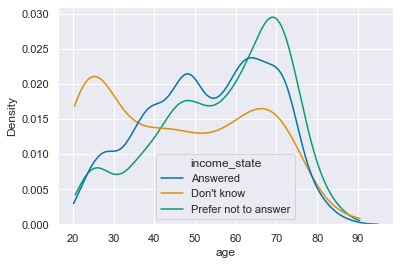

In [31]:
sns.kdeplot(data=df,x='age',hue='income_state',weights=df["wt"],cut=0,common_norm=False)

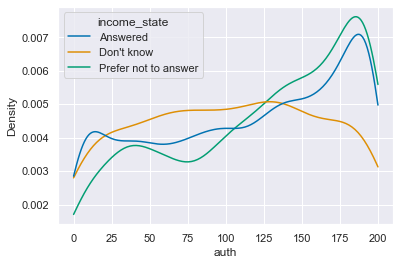

In [32]:
sns.kdeplot(data=df,x='auth',hue='income_state',weights=df["wt"],cut=0,common_norm=False)

In [33]:
(df["auth"]*df["wt"]).dropna().mean()

106.20640326742246

In [25]:
def amalgamate_waves(df, pattern, forward_fill=True, specify_wave_order = None, low_priority_values = [], match=True):
    # euref_imm = amalgamate_waves(BES_reduced_with_na,"euRefVoteW",forward_fill=False)
    # assumes simple wave structure, give a pattern that works!
    if match:
        df_cols_dict = {int(re.search("W(\d+)", x).groups()[0]):x for x in df.columns if re.match(pattern, x)}
    else:
        df_cols_dict = {int(re.search("W(\d+)", x).groups()[0]):x for x in df.columns if re.search(pattern, x)}
    # sort columns
    if specify_wave_order is not None:
        df_cols = [df_cols_dict[x] for x in specify_wave_order]
    else:
        df_cols = [df_cols_dict[x] for x in sorted(df_cols_dict.keys())]
    
    # forward fill and and pick last column - or backward fill and pick first column
    if len(df_cols)<=1:
        raise Exception("Can't amalgamate less than two variables!")
    if forward_fill:
        pick_col = -1
        method = "ffill"        
    else:
        pick_col = 0
        method = "bfill"
    latest_series = df[df_cols]\
        .replace(low_priority_values,[np.nan]*len(low_priority_values))\
        .fillna(method=method,axis=1)[df_cols[pick_col]]
    # stop values in low_priority from cascading, overwrite where possible, otherwise reinsert where there are only nans 
    categories = df[df_cols[0]].cat.categories
    if low_priority_values:
        high_priority_values = [x for x in categories if x not in low_priority_values]
        low_priority_series = df[df_cols]\
                .replace(high_priority_values,[np.nan]*len(high_priority_values))\
                .fillna(method=method,axis=1)[df_cols[pick_col]]
        low_priority_mask = low_priority_series.apply(lambda x: x in low_priority_values) & latest_series.isnull()
        latest_series.loc[low_priority_mask] = low_priority_series.loc[low_priority_mask]

        
            
    # if it's a category, retain category type/options/order
    if df[df_cols[0]].dtype.name == "category":
        latest_series = latest_series.astype(
                    pd.api.types.CategoricalDtype(categories) )
    # update name
    # re.match("(.*?)W\d+","climateChangeW11").groups()[0]
    print("Amalgamating variables: ")
    print(df_cols_dict,df_cols)
    name_stub = re.match("(.*?)W\d+",  list(df_cols_dict.values())[0]).groups()[0]
    latest_series.name = name_stub+"W"+"&".join([str(x) for x in sorted(df_cols_dict.keys())])
    
    return latest_series

In [12]:
# replace_dict = {'Â under £5,000 per year':'under £5,000 per year', 'Â £5,000 to £9,999 per year':'Â £5,000 to £9,999 per year',
#        'Â £10,000 to £14,999 per year','£10,000 to £14,999 per year' 'Â £15,000 to £19,999 per year',
#        'Â £20,000 to £24,999 per year', 'Â £25,000 to £29,999 per year',
#        'Â £30,000 to £34,999 per year', 'Â £35,000 to £39,999 per year',
#        'Â £40,000 to £44,999 per year', 'Â £45,000 to £49,999 per year',
#        'Â £50,000 to £59,999 per year', 'Â £60,000 to £69,999 per year',
#        'Â £70,000 to £99,999 per year', 'Â £100,000 and over', 'Â Don't know',
#        'Â Prefer not to answer'}
replace_dict = {x:x.replace("Â ","") for x in BES_Panel["p_gross_personalW19"].cat.categories}
df = BES_Panel[search(BES_Panel,"p_gross_personal").index].apply(lambda x: x.cat.rename_categories(replace_dict))

In [26]:
df_amalg = amalgamate_waves(df, "p_gross_personal", forward_fill=True, specify_wave_order = None, low_priority_values = ["Don't know",
       'Prefer not to answer'], match=True)

Amalgamating variables: 
{1: 'p_gross_personalW1', 2: 'p_gross_personalW2', 3: 'p_gross_personalW3', 4: 'p_gross_personalW4', 5: 'p_gross_personalW5', 6: 'p_gross_personalW6', 7: 'p_gross_personalW7', 8: 'p_gross_personalW8', 9: 'p_gross_personalW9', 10: 'p_gross_personalW10', 11: 'p_gross_personalW11', 12: 'p_gross_personalW12', 13: 'p_gross_personalW13', 14: 'p_gross_personalW14', 15: 'p_gross_personalW15', 16: 'p_gross_personalW16', 17: 'p_gross_personalW17', 18: 'p_gross_personalW18', 19: 'p_gross_personalW19'} ['p_gross_personalW1', 'p_gross_personalW2', 'p_gross_personalW3', 'p_gross_personalW4', 'p_gross_personalW5', 'p_gross_personalW6', 'p_gross_personalW7', 'p_gross_personalW8', 'p_gross_personalW9', 'p_gross_personalW10', 'p_gross_personalW11', 'p_gross_personalW12', 'p_gross_personalW13', 'p_gross_personalW14', 'p_gross_personalW15', 'p_gross_personalW16', 'p_gross_personalW17', 'p_gross_personalW18', 'p_gross_personalW19']


In [30]:
df_amalg.value_counts(dropna=False)

Prefer not to answer           18220
£10,000 to £14,999 per year    10378
£15,000 to £19,999 per year     9310
£20,000 to £24,999 per year     8758
£5,000 to £9,999 per year       8489
under £5,000 per year           7480
£25,000 to £29,999 per year     6887
£30,000 to £34,999 per year     5301
NaN                             4728
Don't know                      3949
£35,000 to £39,999 per year     3608
£40,000 to £44,999 per year     2695
£50,000 to £59,999 per year     2100
£45,000 to £49,999 per year     1762
£70,000 to £99,999 per year     1368
£60,000 to £69,999 per year     1167
£100,000 and over                806
Name: p_gross_personalW1&2&3&4&5&6&7&8&9&10&11&12&13&14&15&16&17&18&19, dtype: int64

In [39]:
df_amalg_save = df_amalg.copy()

In [28]:
df_amalg = amalgamate_waves(df, "p_gross_personal", forward_fill=True, specify_wave_order = None, low_priority_values = [], match=True)
df_amalg.value_counts(dropna=False)

Amalgamating variables: 
{1: 'p_gross_personalW1', 2: 'p_gross_personalW2', 3: 'p_gross_personalW3', 4: 'p_gross_personalW4', 5: 'p_gross_personalW5', 6: 'p_gross_personalW6', 7: 'p_gross_personalW7', 8: 'p_gross_personalW8', 9: 'p_gross_personalW9', 10: 'p_gross_personalW10', 11: 'p_gross_personalW11', 12: 'p_gross_personalW12', 13: 'p_gross_personalW13', 14: 'p_gross_personalW14', 15: 'p_gross_personalW15', 16: 'p_gross_personalW16', 17: 'p_gross_personalW17', 18: 'p_gross_personalW18', 19: 'p_gross_personalW19'} ['p_gross_personalW1', 'p_gross_personalW2', 'p_gross_personalW3', 'p_gross_personalW4', 'p_gross_personalW5', 'p_gross_personalW6', 'p_gross_personalW7', 'p_gross_personalW8', 'p_gross_personalW9', 'p_gross_personalW10', 'p_gross_personalW11', 'p_gross_personalW12', 'p_gross_personalW13', 'p_gross_personalW14', 'p_gross_personalW15', 'p_gross_personalW16', 'p_gross_personalW17', 'p_gross_personalW18', 'p_gross_personalW19']


Prefer not to answer           18220
£10,000 to £14,999 per year    10378
£15,000 to £19,999 per year     9310
£20,000 to £24,999 per year     8758
£5,000 to £9,999 per year       8489
under £5,000 per year           7480
£25,000 to £29,999 per year     6887
£30,000 to £34,999 per year     5301
NaN                             4728
Don't know                      3949
£35,000 to £39,999 per year     3608
£40,000 to £44,999 per year     2695
£50,000 to £59,999 per year     2100
£45,000 to £49,999 per year     1762
£70,000 to £99,999 per year     1368
£60,000 to £69,999 per year     1167
£100,000 and over                806
Name: p_gross_personalW1&2&3&4&5&6&7&8&9&10&11&12&13&14&15&16&17&18&19, dtype: int64

In [31]:
df_amalg = amalgamate_waves(df.replace("Don't know",np.nan).replace("Prefer not to answer",np.nan),
                            "p_gross_personal", forward_fill=True, specify_wave_order = None, low_priority_values = [], match=True)
df_amalg.value_counts(dropna=False)

Amalgamating variables: 
{1: 'p_gross_personalW1', 2: 'p_gross_personalW2', 3: 'p_gross_personalW3', 4: 'p_gross_personalW4', 5: 'p_gross_personalW5', 6: 'p_gross_personalW6', 7: 'p_gross_personalW7', 8: 'p_gross_personalW8', 9: 'p_gross_personalW9', 10: 'p_gross_personalW10', 11: 'p_gross_personalW11', 12: 'p_gross_personalW12', 13: 'p_gross_personalW13', 14: 'p_gross_personalW14', 15: 'p_gross_personalW15', 16: 'p_gross_personalW16', 17: 'p_gross_personalW17', 18: 'p_gross_personalW18', 19: 'p_gross_personalW19'} ['p_gross_personalW1', 'p_gross_personalW2', 'p_gross_personalW3', 'p_gross_personalW4', 'p_gross_personalW5', 'p_gross_personalW6', 'p_gross_personalW7', 'p_gross_personalW8', 'p_gross_personalW9', 'p_gross_personalW10', 'p_gross_personalW11', 'p_gross_personalW12', 'p_gross_personalW13', 'p_gross_personalW14', 'p_gross_personalW15', 'p_gross_personalW16', 'p_gross_personalW17', 'p_gross_personalW18', 'p_gross_personalW19']


NaN                            20019
£10,000 to £14,999 per year    11435
£15,000 to £19,999 per year    10203
£20,000 to £24,999 per year     9515
£5,000 to £9,999 per year       9477
under £5,000 per year           8597
£25,000 to £29,999 per year     7492
£30,000 to £34,999 per year     5706
£35,000 to £39,999 per year     3903
£40,000 to £44,999 per year     2906
£50,000 to £59,999 per year     2248
£45,000 to £49,999 per year     1905
£70,000 to £99,999 per year     1463
£60,000 to £69,999 per year     1241
£100,000 and over                896
Name: p_gross_personalW1&2&3&4&5&6&7&8&9&10&11&12&13&14&15&16&17&18&19, dtype: int64

In [37]:
low_priority_categories = ["Don't know","Prefer not to answer"]
high_priority_categories = [x for x in df["p_gross_personalW19"].cat.categories if x not in low_priority_categories]
# df.replace(high_priority_categories,[np.nan]*len(high_priority_categories))
df_amalg_low = amalgamate_waves(df.apply(lambda x: x.cat.remove_categories(high_priority_categories)),
                            "p_gross_personal", forward_fill=True, specify_wave_order = None, low_priority_values = [], match=True)
df_amalg_low.value_counts(dropna=False)

Amalgamating variables: 
{1: 'p_gross_personalW1', 2: 'p_gross_personalW2', 3: 'p_gross_personalW3', 4: 'p_gross_personalW4', 5: 'p_gross_personalW5', 6: 'p_gross_personalW6', 7: 'p_gross_personalW7', 8: 'p_gross_personalW8', 9: 'p_gross_personalW9', 10: 'p_gross_personalW10', 11: 'p_gross_personalW11', 12: 'p_gross_personalW12', 13: 'p_gross_personalW13', 14: 'p_gross_personalW14', 15: 'p_gross_personalW15', 16: 'p_gross_personalW16', 17: 'p_gross_personalW17', 18: 'p_gross_personalW18', 19: 'p_gross_personalW19'} ['p_gross_personalW1', 'p_gross_personalW2', 'p_gross_personalW3', 'p_gross_personalW4', 'p_gross_personalW5', 'p_gross_personalW6', 'p_gross_personalW7', 'p_gross_personalW8', 'p_gross_personalW9', 'p_gross_personalW10', 'p_gross_personalW11', 'p_gross_personalW12', 'p_gross_personalW13', 'p_gross_personalW14', 'p_gross_personalW15', 'p_gross_personalW16', 'p_gross_personalW17', 'p_gross_personalW18', 'p_gross_personalW19']


NaN                     68638
Prefer not to answer    22658
Don't know               5710
Name: p_gross_personalW1&2&3&4&5&6&7&8&9&10&11&12&13&14&15&16&17&18&19, dtype: int64

In [ ]:
df_amalg.cat.add_categories(["Don't know","Prefer not to answer"],inplace=True)

In [46]:
df_amalg.loc[df_amalg.isnull()] = df_amalg_low[df_amalg.isnull()].astype('object')

In [50]:
df_amalg.value_counts(dropna=False)

Prefer not to answer           12792
£10,000 to £14,999 per year    11435
£15,000 to £19,999 per year    10203
£20,000 to £24,999 per year     9515
£5,000 to £9,999 per year       9477
under £5,000 per year           8597
£25,000 to £29,999 per year     7492
£30,000 to £34,999 per year     5706
NaN                             4728
£35,000 to £39,999 per year     3903
£40,000 to £44,999 per year     2906
Don't know                      2499
£50,000 to £59,999 per year     2248
£45,000 to £49,999 per year     1905
£70,000 to £99,999 per year     1463
£60,000 to £69,999 per year     1241
£100,000 and over                896
Name: p_gross_personalW1&2&3&4&5&6&7&8&9&10&11&12&13&14&15&16&17&18&19, dtype: int64

In [51]:
df_amalg_save.value_counts(dropna=False)

NaN                            20019
£10,000 to £14,999 per year    11435
£15,000 to £19,999 per year    10203
£20,000 to £24,999 per year     9515
£5,000 to £9,999 per year       9477
under £5,000 per year           8597
£25,000 to £29,999 per year     7492
£30,000 to £34,999 per year     5706
£35,000 to £39,999 per year     3903
£40,000 to £44,999 per year     2906
£50,000 to £59,999 per year     2248
£45,000 to £49,999 per year     1905
£70,000 to £99,999 per year     1463
£60,000 to £69,999 per year     1241
£100,000 and over                896
Name: p_gross_personalW1&2&3&4&5&6&7&8&9&10&11&12&13&14&15&16&17&18&19, dtype: int64

In [59]:
fixedPNTA = (df["p_gross_personalW19"]=="Prefer not to answer") & (df_amalg!="Prefer not to answer")
fixedDK = (df["p_gross_personalW19"]=="Don't know") & (df_amalg!="Don't know")

In [58]:
df_amalg[fixedPNTA].value_counts().sort_index()

under £5,000 per year          310
£5,000 to £9,999 per year      342
£10,000 to £14,999 per year    391
£15,000 to £19,999 per year    347
£20,000 to £24,999 per year    270
£25,000 to £29,999 per year    234
£30,000 to £34,999 per year    169
£35,000 to £39,999 per year    120
£40,000 to £44,999 per year     83
£45,000 to £49,999 per year     56
£50,000 to £59,999 per year     66
£60,000 to £69,999 per year     22
£70,000 to £99,999 per year     34
£100,000 and over               38
Don't know                       0
Prefer not to answer             0
Name: p_gross_personalW1&2&3&4&5&6&7&8&9&10&11&12&13&14&15&16&17&18&19, dtype: int64

In [60]:
df_amalg[fixedDK].value_counts().sort_index()

under £5,000 per year          138
£5,000 to £9,999 per year      121
£10,000 to £14,999 per year    103
£15,000 to £19,999 per year     77
£20,000 to £24,999 per year     60
£25,000 to £29,999 per year     48
£30,000 to £34,999 per year     32
£35,000 to £39,999 per year     26
£40,000 to £44,999 per year     11
£45,000 to £49,999 per year     10
£50,000 to £59,999 per year      7
£60,000 to £69,999 per year      6
£70,000 to £99,999 per year      9
£100,000 and over                5
Don't know                       0
Prefer not to answer             0
Name: p_gross_personalW1&2&3&4&5&6&7&8&9&10&11&12&13&14&15&16&17&18&19, dtype: int64

In [62]:
df_amalg.value_counts().sort_index()

under £5,000 per year           8597
£5,000 to £9,999 per year       9477
£10,000 to £14,999 per year    11435
£15,000 to £19,999 per year    10203
£20,000 to £24,999 per year     9515
£25,000 to £29,999 per year     7492
£30,000 to £34,999 per year     5706
£35,000 to £39,999 per year     3903
£40,000 to £44,999 per year     2906
£45,000 to £49,999 per year     1905
£50,000 to £59,999 per year     2248
£60,000 to £69,999 per year     1241
£70,000 to £99,999 per year     1463
£100,000 and over                896
Don't know                      2499
Prefer not to answer           12792
Name: p_gross_personalW1&2&3&4&5&6&7&8&9&10&11&12&13&14&15&16&17&18&19, dtype: int64

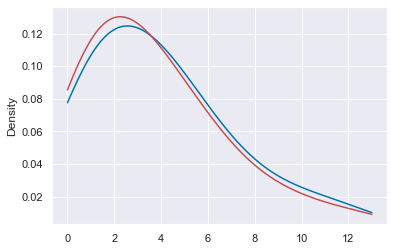

In [68]:
sns.kdeplot(df_amalg.replace("Don't know",np.nan).replace("Prefer not to answer",np.nan).cat.codes.replace(-1,np.nan),bw=.5,cut=0)
sns.kdeplot(df_amalg[fixedPNTA].replace("Don't know",np.nan).replace("Prefer not to answer",np.nan).cat.codes.replace(-1,np.nan),bw=.5,c='r',cut=0)


In [ ]:
### huh!

In [ ]:
%%time
dataset_name = "W19_comb"
df_list = "BES_Panel|BES_reduced_with_na"

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
# pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()
pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')


Toggle code

In [20]:
search(BES_reduced,"profile_gross_personal")

profile_gross_personal__£100,000 and over    92587
dtype: int64

In [74]:
BES_Panel["p_gross_personal"].value_counts()

Â Prefer not to answer             6087
Â Â£10,000 to Â£14,999 per year    3657
Â Â£20,000 to Â£24,999 per year    3085
Â Â£15,000 to Â£19,999 per year    3067
Â Â£5,000 to Â£9,999 per year      2738
Â Â£25,000 to Â£29,999 per year    2445
Â under Â£5,000 per year           2235
Â Â£30,000 to Â£34,999 per year    1831
Â Â£35,000 to Â£39,999 per year    1288
Â Don't know                       1195
Â Â£40,000 to Â£44,999 per year    1019
Â Â£50,000 to Â£59,999 per year     806
Â Â£45,000 to Â£49,999 per year     662
Â Â£70,000 to Â£99,999 per year     483
Â Â£60,000 to Â£69,999 per year     399
Â Â£100,000 and over                218
Name: p_gross_personal, dtype: int64

In [39]:
BES_reduced_with_na.shape,BES_Panel.shape

((92587, 586), (30842, 449))

In [41]:
BES_Panel

,starttime,endtime,wt,turnoutUKGeneral,generalElectionVote,generalElectionVoteTIG,partyIdStrength,partyId,partyIdSqueeze,partyIdTIG,...,profile_house_tenure,profile_marital_stat,profile_past_vote_2017,profile_turnout_2017,profile_past_vote_2015,profile_turnout_2015,profile_eurefvote,profile_eurefturnout,profile_scotref_turnout,profile_scotref_vote
id,,,,,,,,,,,,,,,,,,,,,
3,2019-03-27 15:03:20.280,2019-03-28 08:37:57.617,0.537417,Fairly likely,Don't know,Don't know,Not very strong,Liberal Democrat,NaN,Liberal Democrat,...,Own - outright,Widowed,Labour,"Yes, voted",Labour,"Yes, voted",Leave the EU,"Yes, voted",NaN,NaN
7,2019-03-20 20:30:10.441,2019-03-20 20:59:36.926,0.517418,Very likely that I would vote,Labour,Scottish National Party (SNP),Fairly strong,Scottish National Party (SNP),NaN,Scottish National Party (SNP),...,Own - outright,Married,Scottish National Party (SNP),"Yes, voted",Scottish National Party (SNP),"Yes, voted",Stay/remain in the EU,"Yes, voted","Yes, I voted",I voted 'No' (Scotland should not be an indepe...
8,2019-03-13 09:46:35.893,2019-03-13 10:27:37.451,0.646080,Very likely that I would vote,Other,Other,Fairly strong,Conservative,NaN,Conservative,...,Own - outright,Married,Conservative,"Yes, voted",United Kingdom Independence Party (UKIP),"Yes, voted",Leave the EU,"Yes, voted",NaN,NaN
9,2019-03-22 22:52:00.197,2019-03-22 23:23:38.041,0.719559,Very likely that I would vote,Liberal Democrat,Change UK- The Independent Group,NaN,No - none,No - none,The Independent Group,...,Own - outright,Never married,Liberal Democrat,"Yes, voted",Labour,"Yes, voted",Stay/remain in the EU,"Yes, voted",NaN,NaN
10,2019-03-16 14:41:03.300,2019-03-16 15:26:15.403,0.552374,Fairly likely,Don't know,Don't know,Fairly strong,Conservative,NaN,Conservative,...,Own - outright,Widowed,Conservative,"Yes, voted",Conservative,"Yes, voted",Stay/remain in the EU,"Yes, voted",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81104,2019-03-24 16:25:52.521,2019-03-24 16:44:10.728,0.930149,Very likely that I would vote,Don't know,Don't know,Not very strong,Conservative,NaN,9999,...,NaN,Living as married,Conservative,"Yes, voted",Conservative,"Yes, voted",Stay/remain in the EU,"Yes, voted",NaN,NaN
81105,2019-03-25 12:53:20.932,2019-03-25 14:25:25.324,1.559311,Fairly likely,Scottish National Party (SNP),Don't know,Don't know,Don't know,Scottish National Party (SNP),Scottish National Party (SNP),...,Rent - from a housing association,Living as married,NaN,"No, did not vote",NaN,"No, did not vote",NaN,"No, did not vote",Don't know,NaN
81106,2019-03-24 13:42:51.250,2019-03-24 14:20:59.343,0.545360,Very likely that I would vote,Conservative,Conservative,Fairly strong,Conservative,NaN,Conservative,...,NaN,Married,Conservative,"Yes, voted",Conservative,"Yes, voted",Stay/remain in the EU,"Yes, voted","Yes, I voted",I voted 'No' (Scotland should not be an indepe...


In [46]:
BES_reduced_with_na.index = BES_Panel.index

In [47]:
BES_reduced_with_na["PNTA"] = BES_Panel["profile_gross_personal"]==BES_Panel["profile_gross_personal"].cat.categories[-2]
BES_reduced_with_na["PNTA"].loc[BES_Panel["profile_gross_personal"].isnull()]=np.nan

In [64]:
BES_reduced_with_na["PNTA_household"] = BES_Panel["profile_gross_household"]==BES_Panel["profile_gross_household"].cat.categories[-2]
BES_reduced_with_na["PNTA_household"].loc[BES_Panel["profile_gross_household"].isnull()]=np.nan

In [143]:
BES_reduced_with_na.shape,BES_Panel.shape

((31468, 743), (97006, 8079))

In [48]:
PNTA_corr = BES_reduced_with_na.corrwith(BES_reduced_with_na["PNTA"])

In [49]:
PNTA_corr.sort_values().head(50)

likeBerry__Strongly like                                                               -0.091291
workingStatus_Working full time (30 or more hours per week)                            -0.088831
likeLab__Strongly like                                                                 -0.088450
socialDistRemain__Very happy                                                           -0.087440
likeCorbyn__Strongly like                                                              -0.084283
ptvLab__Very likely                                                                    -0.082739
competentCorbyn__A great deal of competence                                            -0.076919
integrityCorbyn__Complete integrity                                                    -0.076903
handleEUNegotiateLab__Very well                                                        -0.073151
echr__Strongly agree                                                                   -0.071421
grnUnited__Very united        

In [84]:
PNTA_corr.sort_values().tail(50)

immigGreen__Allow many more                                                                              0.020067
infoSourceTV__More than 2 hours                                                                          0.022436
cvSeverityClose__They passed away                                                                        0.023411
privateEnterprise__Strongly agree                                                                        0.024835
empathy6__Strongly agree                                                                                 0.025146
likeJohnson__Strongly like                                                                               0.025632
taxSpendLab__Government should increase taxes a lot and spend much more on health and social services    0.025821
EUIntegrationCon__Protect our independence                                                               0.025960
partnerOccOrgSizeLast__500 or more employees                                            

In [56]:
BES_reduced_with_na["PNTA"].corr( BES_Panel["genTrustW15"].cat.codes.replace(-1,np.nan).replace(2,np.nan) )

0.053986717190751904

In [58]:
BES_reduced_with_na["genTrustW15_can't_be_too_careful"] = BES_Panel["genTrustW15"].cat.codes.replace(-1,np.nan).replace(2,np.nan)

In [59]:
search(BES_reduced_with_na,"profile_gross")

profile_gross_household__£150,000 and over    23169
profile_gross_personal__£100,000 and over     44395
dtype: int64

In [57]:
BES_Panel["genTrustW15"]

id
1.0                               NaN
2.0                               NaN
3.0        Most people can be trusted
4.0                               NaN
5.0                               NaN
                      ...            
94883.0                           NaN
94884.0                           NaN
94885.0                           NaN
94886.0                           NaN
94887.0                           NaN
Name: genTrustW15, Length: 92587, dtype: category
Categories (3, object): [Most people can be trusted < Can't be too careful < Don't know]

In [131]:
BES_reduced_with_na

,turnoutUKGeneral__Very likely that I will vote,partyIdStrength__Not very strong,polAttention__Pay a great deal of attention,pidWeThey__Strongly agree,pidInterestedOthers__Strongly agree,pidCriticiseParty__Strongly agree,pidCommonParty__Strongly agree,pidRuinDay__Strongly agree,pidConnected__Strongly agree,pidMyParty__Strongly agree,...,responsibleEconC_6_Yes,responsibleEconC_5_Yes,responsibleEconC_4_Yes,responsibleEconC_3_Yes,responsibleEconC_2_Yes,responsibleEconC_1_Yes,coronaMeasures_2_Yes,coronaMeasures_1_Yes,coronaMeasures_4_Yes,PNTA
id,,,,,,,,,,,,,,,,,,,,,
2,4.0,2.0,7.0,1.0,1.0,1.0,NaN,0.0,2.0,1.0,...,False,<NA>,<NA>,True,False,False,True,False,False,0.0
7,4.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,<NA>,False,False,False,True,True,True,True,0.0
8,4.0,2.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,<NA>,<NA>,True,False,False,True,True,False,0.0
9,4.0,2.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,<NA>,True,False,False,True,True,False,0.0
15,4.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,<NA>,<NA>,True,False,False,True,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102854,4.0,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,<NA>,False,True,False,True,True,False,False,0.0
102855,4.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,<NA>,<NA>,True,False,False,True,True,False,0.0
102856,4.0,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,<NA>,<NA>,True,False,True,True,True,False,0.0


In [62]:
search(BES_Panel,"wt_new_W15")

wt_new_W15    30842
dtype: int64

[0]	validation_0-rmse:0.490383
Will train until validation_0-rmse hasn't improved in 50.0 rounds.
[1]	validation_0-rmse:0.481498
[2]	validation_0-rmse:0.473414
[3]	validation_0-rmse:0.46601
[4]	validation_0-rmse:0.459183
[5]	validation_0-rmse:0.452907
[6]	validation_0-rmse:0.446966
[7]	validation_0-rmse:0.441578
[8]	validation_0-rmse:0.436647
[9]	validation_0-rmse:0.432235
[10]	validation_0-rmse:0.428138
[11]	validation_0-rmse:0.424284
[12]	validation_0-rmse:0.42073
[13]	validation_0-rmse:0.417671
[14]	validation_0-rmse:0.414729
[15]	validation_0-rmse:0.412143
[16]	validation_0-rmse:0.409682
[17]	validation_0-rmse:0.407511
[18]	validation_0-rmse:0.405556
[19]	validation_0-rmse:0.403851
[20]	validation_0-rmse:0.402239
[21]	validation_0-rmse:0.400765
[22]	validation_0-rmse:0.39928
[23]	validation_0-rmse:0.398027
[24]	validation_0-rmse:0.396868
[25]	validation_0-rmse:0.395726
[26]	validation_0-rmse:0.394786
[27]	validation_0-rmse:0.39404
[28]	validation_0-rmse:0.393294
[29]	validation_0-r

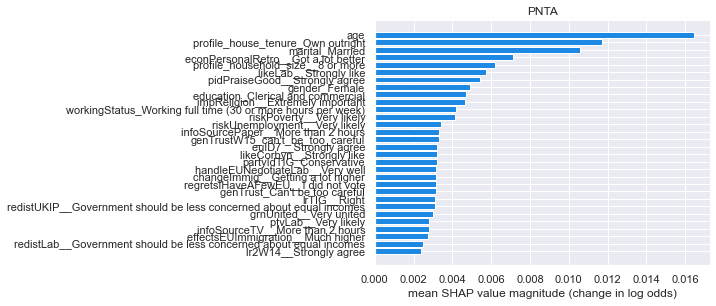

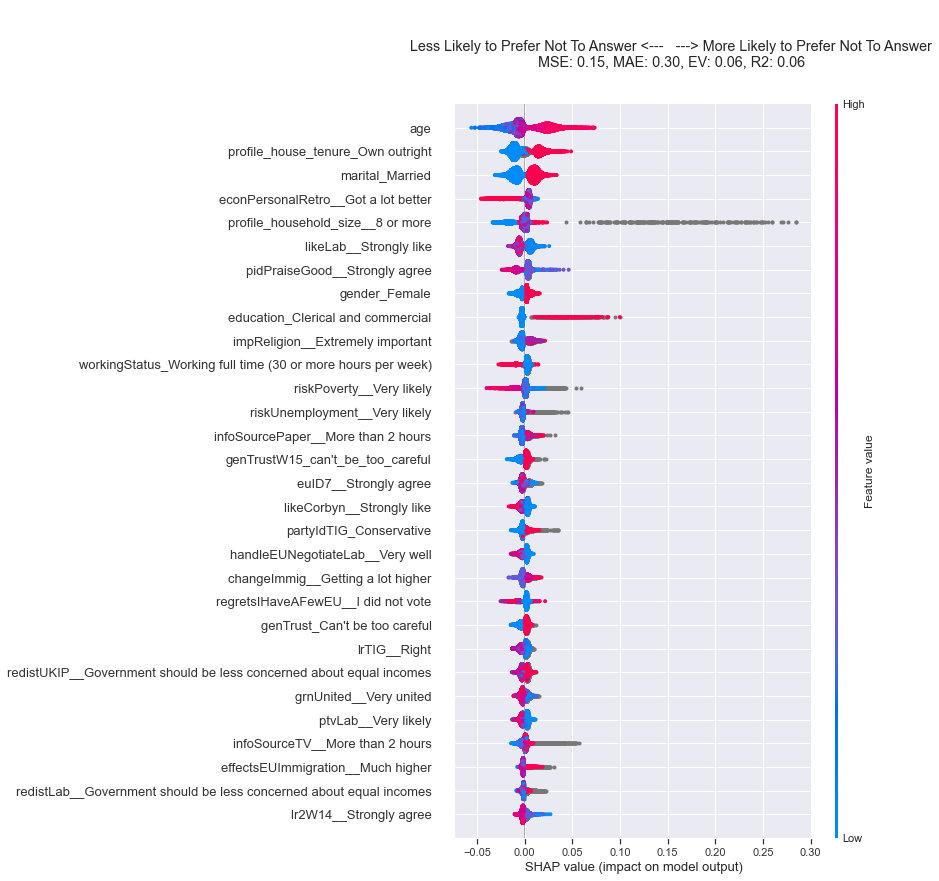

Wall time: 48 s


(<shap.explainers.tree.TreeExplainer at 0x33937288>,
 array([[-4.6675259e-04, -8.6744993e-05,  3.5024204e-05, ...,
         -6.2440071e-05, -2.8068267e-04, -6.6890633e-03],
        [-1.2940331e-04, -9.3010640e-05, -2.4040196e-06, ...,
         -3.1663345e-05,  1.5637141e-03,  4.1072313e-03],
        [-1.0016898e-04, -2.4737406e-05, -3.3576875e-05, ...,
         -3.0277684e-05, -2.3015242e-04, -9.3118269e-03],
        ...,
        [-3.7373314e-04,  1.1684522e-03, -9.5225505e-06, ...,
          9.0738205e-04, -1.3206454e-03,  4.4466020e-03],
        [-1.6148805e-04, -1.9788260e-05, -1.5753641e-05, ...,
          5.2752567e-04, -9.2764274e-04,  1.7437583e-03],
        [ 1.5640330e-06, -4.6258559e-05,  1.2906905e-05, ...,
          6.1352133e-05, -3.3323097e-04, -6.3170562e-03]], dtype=float32),
 Index(['turnoutUKGeneral__Very likely that I will vote',
        'partyIdStrength__Not very strong', 'partyIdStrengthTIG__3.0',
        'polAttention__Pay a great deal of attention',
        'pidW

In [63]:
%%time
# search(BES_reduced_with_na,"polAttention")
Treatment = "PNTA"
var_stub = "PNTA"

var_list = ["PNTA"]
var_stub_list = [var_stub,"profile_gross"]
BES_reduced_with_na = BES_reduced_with_na.astype('float')
mask = BES_reduced_with_na["PNTA"].notnull() & BES_Panel["wt_new_W15"].notnull()
colname = "ptvLDW18"
xgboost_run(subdir=colname,dataset=BES_reduced_with_na[mask],
            var_list=var_list,var_stub_list=var_stub_list,use_specific_weights=BES_Panel["wt_new_W15"][mask],
            min_features = min(BES_reduced_with_na.shape[1]-1,30),
            title = "\n\nLess Likely to Prefer Not To Answer <---   ---> More Likely to Prefer Not To Answer")

[0]	validation_0-rmse:0.490396
Will train until validation_0-rmse hasn't improved in 7.6000000000000005 rounds.
[1]	validation_0-rmse:0.481728
[2]	validation_0-rmse:0.473602
[3]	validation_0-rmse:0.46623
[4]	validation_0-rmse:0.459339
[5]	validation_0-rmse:0.453134
[6]	validation_0-rmse:0.447488
[7]	validation_0-rmse:0.442223
[8]	validation_0-rmse:0.437302
[9]	validation_0-rmse:0.432991
[10]	validation_0-rmse:0.428918
[11]	validation_0-rmse:0.42524
[12]	validation_0-rmse:0.421772
[13]	validation_0-rmse:0.418659
[14]	validation_0-rmse:0.415876
[15]	validation_0-rmse:0.4134
[16]	validation_0-rmse:0.411071
[17]	validation_0-rmse:0.408885
[18]	validation_0-rmse:0.407005
[19]	validation_0-rmse:0.405206
[20]	validation_0-rmse:0.40358
[21]	validation_0-rmse:0.402115
[22]	validation_0-rmse:0.400814
[23]	validation_0-rmse:0.39968
[24]	validation_0-rmse:0.39847
[25]	validation_0-rmse:0.397402
[26]	validation_0-rmse:0.396485
[27]	validation_0-rmse:0.395644
[28]	validation_0-rmse:0.394873
[29]	val

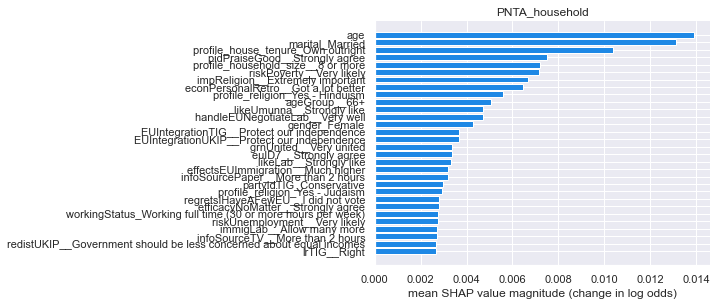

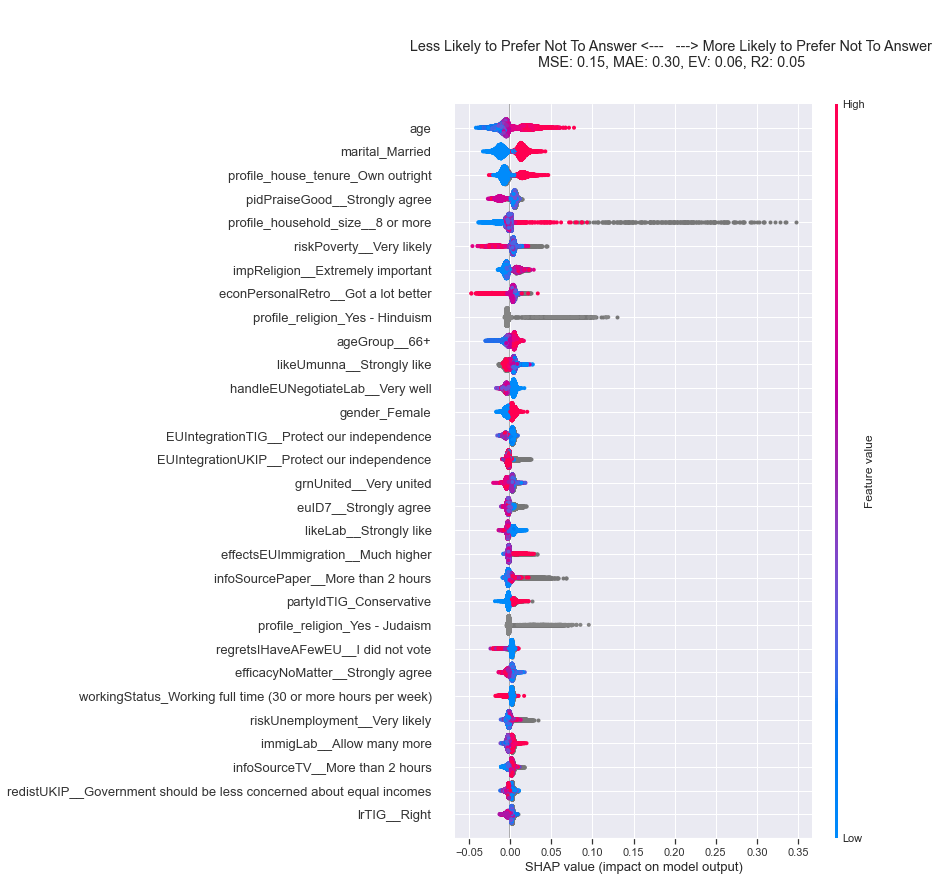

Wall time: 41.2 s


(<shap.explainers.tree.TreeExplainer at 0x170dddc8>,
 array([[ 4.0852028e-06, -5.4206152e-04, -2.9431839e-04, ...,
          5.5038785e-05,  3.7146292e-05, -1.9781145e-03],
        [-4.1249779e-05,  2.1173035e-04,  1.5768909e-04, ...,
          1.0865913e-04,  8.6221989e-05,  1.4307053e-03],
        [-2.0550500e-05, -7.1159877e-05, -5.7180040e-04, ...,
          4.4495324e-04,  4.1392104e-06, -2.3671053e-03],
        ...,
        [ 1.0569865e-06, -8.8077148e-05, -3.1474083e-06, ...,
          9.9798734e-04, -3.1266220e-05,  5.2735553e-04],
        [-5.8859878e-05,  5.1569118e-04,  1.8608970e-04, ...,
         -8.1530679e-04,  9.5013183e-06,  1.8149840e-03],
        [-5.7362164e-03,  9.8137694e-05,  2.7439077e-05, ...,
          4.0031318e-05,  7.9364824e-04,  4.1467868e-04]], dtype=float32),
 Index(['turnoutUKGeneral__Very likely that I will vote',
        'partyIdStrength__Not very strong', 'partyIdStrengthTIG__3.0',
        'polAttention__Pay a great deal of attention',
        'pidW

In [67]:
%%time
# search(BES_reduced_with_na,"polAttention")
Treatment = "PNTA_household"
var_stub = "PNTA_household"

var_list = ["PNTA_household"]
var_stub_list = [var_stub,"profile_gross","PNTA"]
BES_reduced_with_na = BES_reduced_with_na.astype('float')
mask = BES_reduced_with_na["PNTA_household"].notnull() & BES_Panel["wt_new_W15"].notnull()
colname = "PNTA_household"
xgboost_run(subdir=colname,dataset=BES_reduced_with_na[mask],
            var_list=var_list,var_stub_list=var_stub_list,use_specific_weights=BES_Panel["wt_new_W15"][mask],
            min_features = min(BES_reduced_with_na.shape[1]-1,30),
            title = "\n\nLess Likely to Prefer Not To Answer <---   ---> More Likely to Prefer Not To Answer")